In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys
import logging
import pickle
import logging

# Data
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Graph
import tensorflow_gnn as tfgnn

# Add the project root to the Python path
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.data_cleaner import filter_top_cpv_categories
#from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer
from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer, analyze_edge_anomaly_types

from scripts.synthetic_anomaly_generator import SyntheticAnomalyGenerator


%load_ext autoreload
%autoreload 2

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Configuration
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),
                        'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()),
                            'models', 'anomalies')
os.makedirs(MODEL_PATH, exist_ok=True)

# Initialize components
graph_builder = ProcurementGraphBuilder()
gnn_detector = GNNAnomalyDetector(hidden_dim=64, output_dim=32,
                                    num_layers=3)
analyzer = AnomalyAnalyzer()

In [23]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),
                        'data')
 
# Load and preprocess data
X = graph_builder.load_data(DATA_PATH)
# Now using all three splits: train, val, test (with synthetic anomalies)
(X_train_preproc, X_val_preproc, X_test_preproc, 
    X_train, X_val, X_test) = graph_builder.preprocess_data(X)

# Create graphs for all three splits
X_train_graph = graph_builder.create_graph(X_train_preproc, X_train, type='train')
X_val_graph = graph_builder.create_graph(X_val_preproc, X_val, type='val')
X_test_graph = graph_builder.create_graph(X_test_preproc, X_test, type='test')

INFO:scripts.gnn_anomaly_detection:Loading data from /home/ronan/code/RonanB400/Project/decp_ml/data


INFO:scripts.gnn_anomaly_detection:Preprocessing data...


Filtered from 392 to 60 CPV categories, keeping 250895 rows out of 286850


/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
INFO:scripts.gnn_anomaly_detection:Generating synthetic anomalies for test set...
INFO:scripts.synthetic_anomaly_generator:Generating 5017 total synthetic anomaly rows
INFO:scripts.synthetic_anomaly_generator:Approximately 501 anomalies per type
INFO:scripts.synthetic_anomaly_generator:Generating single_bid_competitive anomalies...
INFO:scripts.synthetic_anomaly_generator:Generated 501 single bid competitive anomaly rows
INFO:scripts.synthetic_anomaly_generator:Generating price_inflation anomalies...
INFO:scripts.synthetic_anomaly_generator:Generated 501 price inflation anomaly rows
INFO:scripts.synthetic_anomaly_generator:Generating price_deflation a

In [24]:
# Scale derived node/edge features using training data
logger.info("Scaling derived node and edge features...")
node_features_train = X_train_graph['node_features']
edge_features_train = X_train_graph['edge_features']

# Fit scalers on training data (derived features)
node_features_train_scaled = graph_builder.node_scaler.fit_transform(
    node_features_train)
edge_features_train_scaled = graph_builder.edge_scaler.fit_transform(
    edge_features_train)

# Transform validation features using training scalers
node_features_val = X_val_graph['node_features']
edge_features_val = X_val_graph['edge_features']
node_features_val_scaled = graph_builder.node_scaler.transform(
    node_features_val)
edge_features_val_scaled = graph_builder.edge_scaler.transform(
    edge_features_val)

# Transform test features using training scalers
node_features_test = X_test_graph['node_features']
edge_features_test = X_test_graph['edge_features']
node_features_test_scaled = graph_builder.node_scaler.transform(
    node_features_test)
edge_features_test_scaled = graph_builder.edge_scaler.transform(
    edge_features_test)

# Create TensorFlow graphs for all three splits
X_train_tf_graph = gnn_detector.create_tensorflow_graph(
    X_train_graph, node_features_train_scaled, edge_features_train_scaled)
X_val_tf_graph = gnn_detector.create_tensorflow_graph(
    X_val_graph, node_features_val_scaled, edge_features_val_scaled)
X_test_tf_graph = gnn_detector.create_tensorflow_graph(
    X_test_graph, node_features_test_scaled, edge_features_test_scaled)

# Store graph tensors for later use
gnn_detector.graph_tensor_train = X_train_tf_graph
gnn_detector.graph_tensor_val = X_val_tf_graph
gnn_detector.graph_tensor_test = X_test_tf_graph

INFO:__main__:Scaling derived node and edge features...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...


# Edge anomalies

INFO:scripts.gnn_anomaly_detection:Building GNN model for edge anomaly detection...
INFO:scripts.gnn_anomaly_detection:Training edge GNN model for 100 epochs...


Epoch 1/100


1/1 [==============================] - 5s 5s/step - loss: 1.2949 - edge_embeddings_loss: 0.0389 - edge_reconstructed_loss: 1.4345 - val_loss: 0.9366 - val_edge_embeddings_loss: 0.2185 - val_edge_reconstructed_loss: 1.0164
Epoch 2/100
1/1 [==============================] - 1s 845ms/step - loss: 1.2184 - edge_embeddings_loss: 0.0418 - edge_reconstructed_loss: 1.3491 - val_loss: 0.9247 - val_edge_embeddings_loss: 0.1687 - val_edge_reconstructed_loss: 1.0087
Epoch 3/100
1/1 [==============================] - -2s -1623612us/step - loss: 1.1600 - edge_embeddings_loss: 0.0392 - edge_reconstructed_loss: 1.2846 - val_loss: 0.9185 - val_edge_embeddings_loss: 0.1401 - val_edge_reconstructed_loss: 1.0050
Epoch 4/100
1/1 [==============================] - 1s 915ms/step - loss: 1.1110 - edge_embeddings_loss: 0.0365 - edge_reconstructed_loss: 1.2304 - val_loss: 0.9143 - val_edge_embeddings_loss: 0.1197 - val_edge_reconstructed_loss: 1.0026
Epoch 5/100
1/1 [==============================] - 1s 973ms/s

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets


INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets
INFO:scripts.gnn_anomaly_detection:Edge model saved to /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model


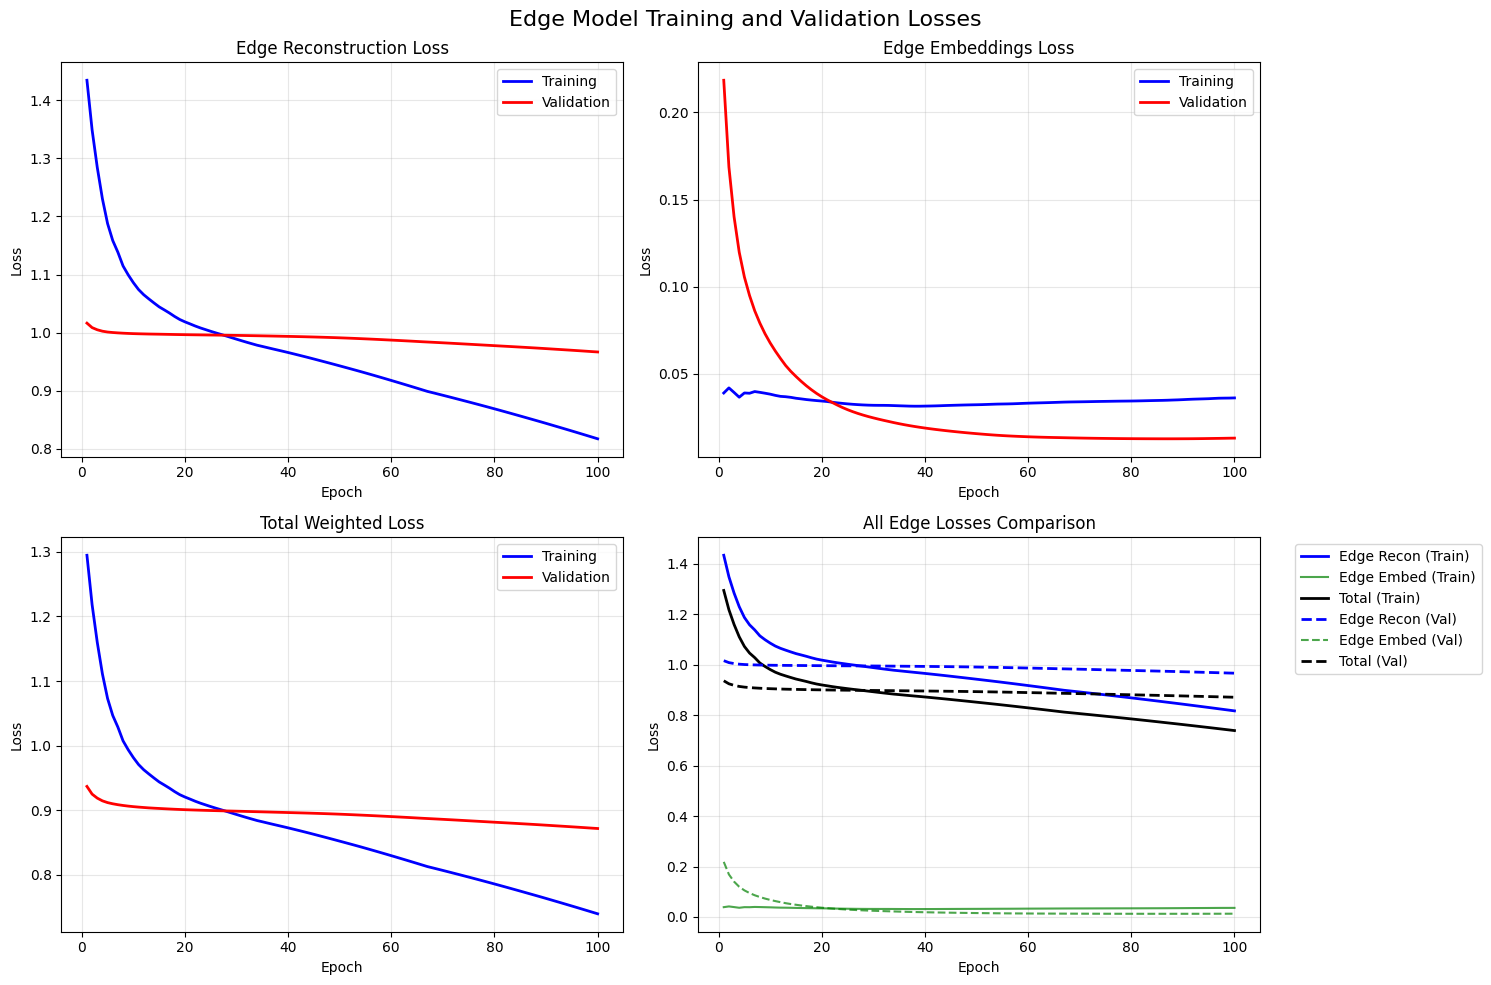


EDGE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Edge Reconstruction: 0.817352
  - Edge Embeddings: 0.036070
  - Total Weighted Loss: 0.739224

Validation Losses (Final Epoch):
  - Edge Reconstruction: 0.966810
  - Edge Embeddings: 0.012984
  - Total Weighted Loss: 0.871428

Training vs Validation Analysis:
  - ⚠️  Potential overfitting (val loss >> train loss)
      Model memorizing training data, poor generalization


In [11]:
gnn_detector.edge_model = gnn_detector.build_edge_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

edge_history = gnn_detector.train_edge_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                         epochs=100)

gnn_detector.plot_edge_training_history(edge_history)

In [29]:
edge_reconstruction_error, edge_threshold = (
            gnn_detector.detect_edge_anomalies(
                X_test_tf_graph,
                threshold_percentile = 90))
        
# Calculate anomaly masks
edge_anomalies = edge_reconstruction_error > edge_threshold

INFO:scripts.gnn_anomaly_detection:Detecting edge anomalies...
INFO:scripts.gnn_anomaly_detection:Original edge features shape: (55188, 94)
INFO:scripts.gnn_anomaly_detection:Original edge features - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Original edge features - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Original edge features stats: min=-44.790066, max=283.346069, mean=0.000386


1/1 [==============================] - 0s 146ms/step


INFO:scripts.gnn_anomaly_detection:Reconstructed edge features shape: (55188, 94)
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features stats: min=-1.732934, max=1.471834, mean=-0.005294
INFO:scripts.gnn_anomaly_detection:Difference - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Difference - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Squared difference - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Squared difference - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors shape: (55188,)
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - % NaN: 0.0%
INFO:scripts.gnn_anomaly_detection:Valid errors count: 55188 out of 55188
INFO:scripts.gnn_anomaly_d

In [30]:
synthetic_analysis = analyzer.analyze_synthetic_anomaly_detection(
            X_test_graph, edge_reconstruction_error, edge_threshold, show_plots=False)

INFO:scripts.gnn_anomaly_detection:Analyzing synthetic anomaly detection performance...



SYNTHETIC ANOMALY DETECTION ANALYSIS
Dataset Overview:
  - Total contracts: 55,188
  - Normal contracts: 50,179 (90.9%)
  - Synthetic anomalies: 5,009 (9.1%)

Performance by Threshold Percentile:
Percentile   Threshold    Precision  Recall   F1-Score Detected  
----------------------------------------------------------------------
95           3.059239     0.097      0.053    0.069    2760      
97           3.314981     0.103      0.034    0.051    1655      
99           3.780111     0.100      0.011    0.020    552       
99.5         4.173255     0.094      0.005    0.010    276       

Performance by Anomaly Type:
Type                      Count    % Dataset  Detection Rate % vs Random  Avg Error    Status    
-----------------------------------------------------------------------------------------------
Normal                    50179    90.9       10.0            N/A        0.984005     ❌ Very High FP
Single Bid Competitive    501      0.9        10.2            11.2x      1.09

/home/ronan/code/RonanB400/Project/decp_ml/scripts/gnn_anomaly_detection.py:1981: DtypeWarning: Columns (39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  # Ensure we have the same number of edges as reconstruction errors


# Node anomalies

In [ ]:
gnn_detector.node_model = gnn_detector.build_node_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

node_history = gnn_detector.train_node_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                        epochs=50)

gnn_detector.plot_node_training_history(node_history)

In [ ]:

(node_reconstruction_error, edge_reconstruction_error, 
     node_threshold, edge_threshold) = gnn_detector.detect_anomalies()
    
# Calculate anomaly masks
node_anomalies = node_reconstruction_error > node_threshold
edge_anomalies = edge_reconstruction_error > edge_threshold

In [ ]:
 #Create results analysis
graph_data = X_test_graph

analyzer = AnomalyAnalyzer()

node_results_df = analyzer.create_node_results_dataframe(
    graph_data, node_reconstruction_error, node_anomalies)

node_results_df.head()

In [ ]:
edge_results_df = analyzer.create_edge_results_dataframe(
    graph_data, edge_reconstruction_error, edge_anomalies)

edge_results_df.head()

In [ ]:
data_path

In [ ]:
model_path = os.path.join(data_path, 'gnn_anomaly_model.keras')

tf.saved_model.save(gnn_detector.model, model_path)

In [ ]:
graph_builder = ProcurementGraphBuilder()
graph_builder.visualize_procurement_graph(X_train_graph)